# Read a Graph

### Data is the currency of science, but it is packaged in figures

Can we unpackage data and re-use it?

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import IPython
import scipy.ndimage as ndimage
# try:
#     import Image
# except ImportError:
from PIL import Image
import pytesseract as tes

import sys
sys.path.insert(0, './functions')
import ocr_tools
import find_axes
from thresholding import adaptive_thresh

print('All packages loaded')

All packages loaded


<IPython.core.display.Javascript object>


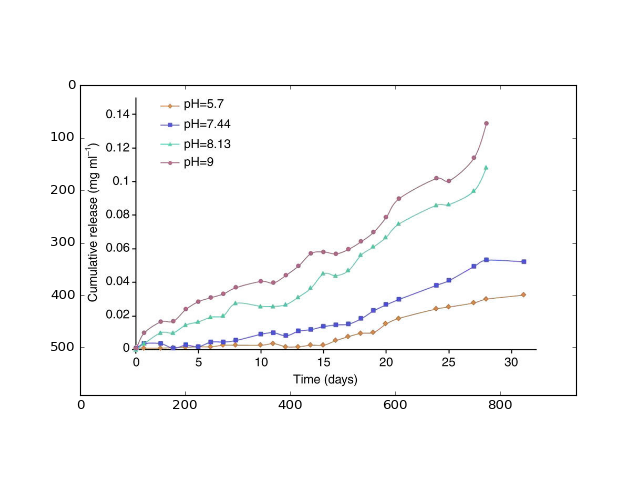

In [85]:
example = 'examples/example103.jpg'
img = cv2.imread(example)
m,n,p=img.shape

%matplotlib notebook
implot = plt.imshow(img)

## This is our starting point

We would like to find the axes, calibrate them from pixel to data space, find the data and extract it.

<IPython.core.display.Javascript object>


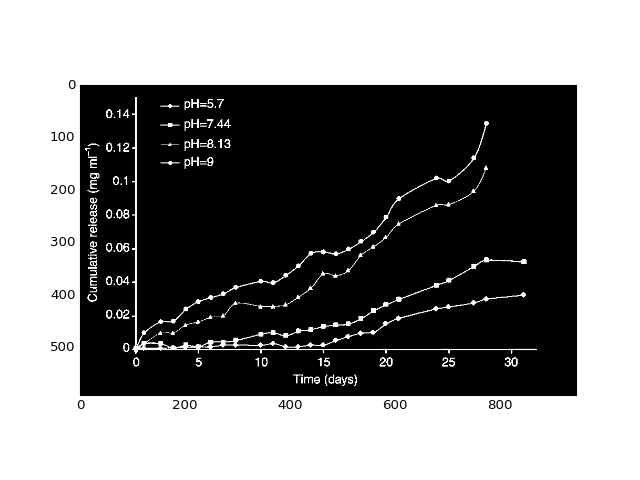

In [86]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
bw4 = adaptive_thresh(gray)
nbw = (255-bw4)

%matplotlib notebook
implot = plt.imshow(nbw, cmap='gray')

### Every image processing workflow starts with a threshold

Many features are available from the black and white image. We will start with a simple one: lines. These are extracted through a Hough Transform

In [87]:
linesP = cv2.HoughLinesP(nbw,1,np.pi/2,2, minLineLength = nbw.shape[1]/10, maxLineGap = 3)[0]
print('Hough Transform complete')
print(linesP[0:4])

Hough Transform complete
[[ 99 504 869 504]
 [ 99 505 869 505]
 [105 512 105  25]
 [107 511 107  25]]


## So we've got some line segments.

Now we are going to engineer an axis feature score, for example, the x-axis:

[cos^2, fractional length, fractional y-coord (or x coord for y axis)]

"How horizontal is this line segment?"
"How long is it relative to the image size?"
"Where is it in the image?"

In [88]:
import find_axes
# print(linesP)
xax = find_axes.get_xaxis(linesP,nbw)
print('x axis')
print(xax)
yax = find_axes.get_yaxis(linesP,nbw)
print('y axis')
print(yax)

x axis
[ 99 504 869 504]
y axis
[107 511 107  25]


## Let's draw the results

<IPython.core.display.Javascript object>


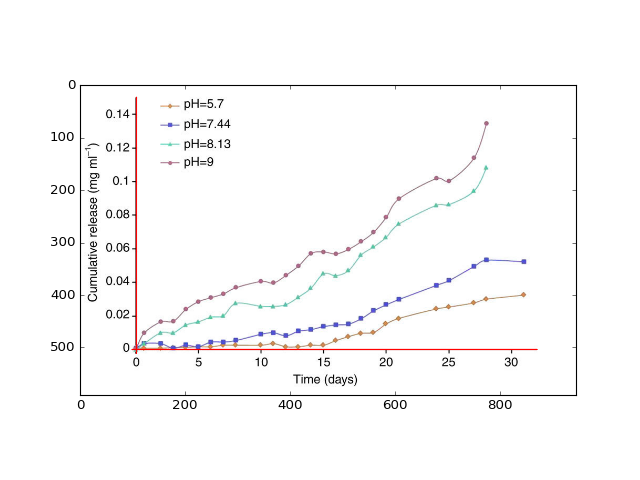

In [89]:
imlabel = img.copy();
cv2.line(imlabel,(xax[0],xax[1]),(xax[2],xax[3]),(255,0,0),2)
cv2.line(imlabel,(yax[0],yax[1]),(yax[2],yax[3]),(255,0,0),2)

%matplotlib notebook
implot = plt.imshow(imlabel)
implot.set_cmap('gray')

## Now let's find ticks and tick labels

It's actually easier to start by finding the labels - in fact, in many cases it's not necessary to even find the ticks at all.

OCR is difficult. Pytesseract is the best open source library for it, but it's not a panacea. We can help it by first isolating the region from which we'd like to extract text.

<IPython.core.display.Javascript object>


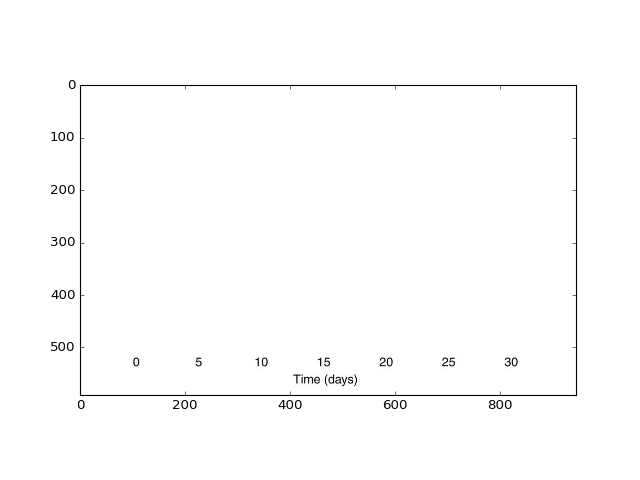

In [90]:
%matplotlib notebook

# Find where the x-ticks stop and crop the text image to be below that
below_xax_bw = np.zeros([m,n]).astype('uint8')
below_xax_bw[xax[1]:,:]=nbw[xax[1]:,:]
row_sums = below_xax_bw.sum(axis=1)
row_sums[0:xax[1]] = 1000
row_sums_list = row_sums.tolist()
text_crop_ind = row_sums_list.index(0)
text_crop_ind

xTextImg = np.ones([m,n,p]).astype('uint8')*255
xTextImg[text_crop_ind+1:,:,:]=img[text_crop_ind+1:,:,:]

cv2.imwrite('temp/xtext.png',xTextImg)
implot = plt.imshow(xTextImg)


In [91]:
xocr = tes.image_to_string(Image.open('temp/xtext.png'),boxes=True)
print('OCR complete')
xocr

OCR complete


'1 334 55 340 71 0\n0 346 54 357 71 0\n1 453 55 459 71 0\n5 465 54 476 71 0\nT 406 22 420 39 0\ni 422 22 424 39 0\nm 427 22 443 35 0\ne 446 22 457 35 0\n( 466 17 471 39 0\nd 473 21 484 39 0\na 486 22 498 35 0\ny 498 17 509 34 0\ns 510 21 520 35 0\n) 522 17 527 39 0\n2 570 55 582 71 0\n0 584 54 595 71 0\n2 689 55 701 71 0\n5 703 54 714 71 0\n3 809 54 820 71 0\n0 822 54 833 71 0'

In [92]:
import ocr_tools

words = ocr_tools.clean_ocr_results(xocr)
words

[['10', 334, 54, 357, 71],
 ['15', 453, 54, 476, 71],
 ['Time', 406, 22, 457, 39],
 ['(days', 466, 17, 520, 39],
 [')', 522, 17, 527, 39],
 ['20', 570, 54, 595, 71],
 ['25', 689, 54, 714, 71],
 ['30', 809, 54, 833, 71]]

### We're looking for numbers

Let's pick those out.

In [93]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

numbers = [w for w in words if is_number(w[0])]
for w in numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
xt_labels = np.array(numbers)
xt_labels

array([[  10.,  334.,  537.,  357.,  520.,  345.,  528.],
       [  15.,  453.,  537.,  476.,  520.,  464.,  528.],
       [  20.,  570.,  537.,  595.,  520.,  582.,  528.],
       [  25.,  689.,  537.,  714.,  520.,  701.,  528.],
       [  30.,  809.,  537.,  833.,  520.,  821.,  528.]])

<IPython.core.display.Javascript object>


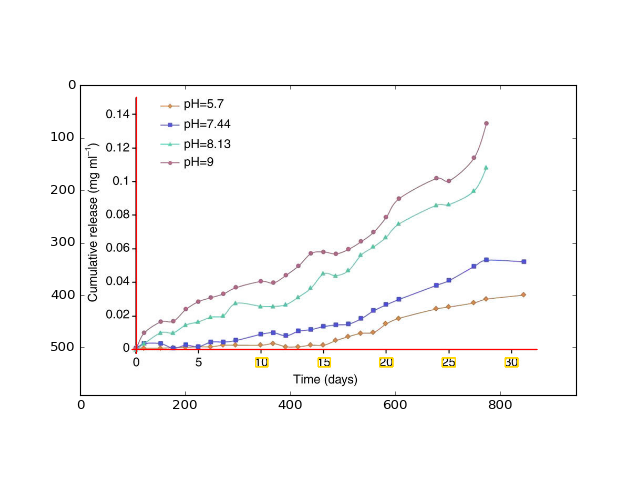

In [94]:
%matplotlib notebook

for w in numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

# Find X Ticks


### This is going to match tick labels with their nearest vertical line segment on the x-axis.

In [95]:
xt_dirty = find_axes.get_xticks(nbw,xax,tickMargin=11,minTickLen=0,maxGap=0)
xt_list=xt_dirty.tolist()
xt_list

[[99, 505, 99, 504],
 [100, 505, 100, 503],
 [101, 505, 101, 501],
 [102, 505, 102, 498],
 [103, 508, 103, 497],
 [104, 507, 104, 497],
 [105, 512, 105, 493],
 [106, 512, 106, 493],
 [107, 511, 107, 497],
 [108, 508, 108, 497],
 [109, 508, 109, 494],
 [110, 505, 110, 493],
 [111, 505, 111, 498],
 [111, 494, 111, 493],
 [112, 505, 112, 497],
 [113, 505, 113, 496],
 [114, 505, 114, 496],
 [115, 505, 115, 501],
 [116, 505, 116, 501],
 [116, 497, 116, 494],
 [117, 505, 117, 500],
 [117, 496, 117, 493],
 [118, 505, 118, 499],
 [119, 505, 119, 498],
 [120, 506, 120, 493],
 [121, 506, 121, 493],
 [122, 505, 122, 493],
 [123, 505, 123, 499],
 [124, 505, 124, 499],
 [125, 505, 125, 501],
 [125, 496, 125, 493],
 [126, 505, 126, 501],
 [126, 493, 126, 493],
 [127, 505, 127, 501],
 [128, 505, 128, 501],
 [129, 505, 129, 501],
 [130, 505, 130, 501],
 [130, 493, 130, 493],
 [131, 505, 131, 501],
 [132, 505, 132, 501],
 [133, 505, 133, 501],
 [134, 505, 134, 501],
 [135, 505, 135, 501],
 [136, 493, 1

In [96]:
xt_match = find_axes.match_xticks(numbers,xt_list)
xt_pts = [xt_list[i] for i in xt_match]
xt_pts

[[344, 512, 344, 503],
 [464, 511, 464, 504],
 [582, 511, 582, 503],
 [702, 512, 702, 503],
 [821, 512, 821, 503]]

<IPython.core.display.Javascript object>


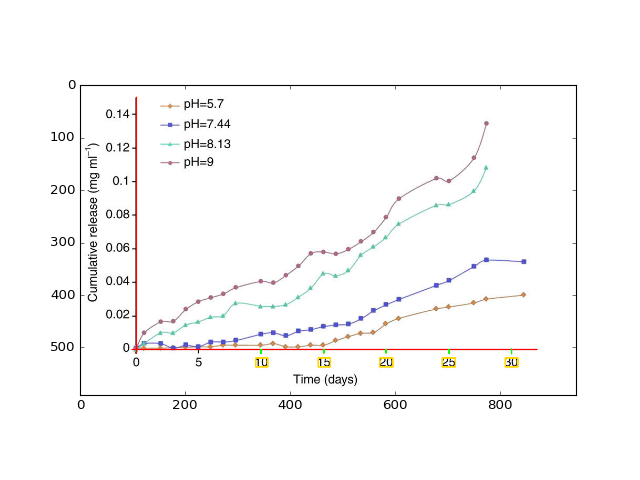

In [97]:
%matplotlib notebook
for x1,y1,x2,y2 in xt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [100]:
xt_pts_array = np.array(xt_pts)
xt_pts_array[:,0].reshape(-1,1)

print('X Axis in pixels')
print(xt_pts_array[:,0].reshape(-1,1))

X Axis in pixels
[[344]
 [464]
 [582]
 [702]
 [821]]


In [101]:
xt_labels[:,0].reshape(-1,1)
print('X Axis in Data')
print(xt_labels[:,0].reshape(-1,1))

X Axis in Data
[[ 10.]
 [ 15.]
 [ 20.]
 [ 25.]
 [ 30.]]


## Convert x-axis from pixel space to data space with regression

We have a sort of calibration curve between pixel space and data space.

<IPython.core.display.Javascript object>


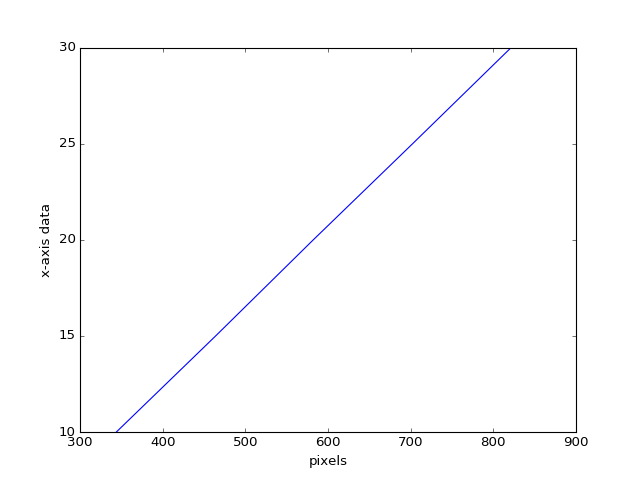

In [102]:
%matplotlib notebook
hcalib = plt.plot(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))
plt.xlabel('pixels')
plt.ylabel('x-axis data')

In [18]:
from sklearn import datasets, linear_model
regrx = linear_model.LinearRegression(fit_intercept=True)

regrx.fit(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regrx.coef_
print 'Intercept: \n', regrx.intercept_

Coefficients: 
[[ 0.00280503]]
Intercept: 
[-0.33099148]


## Now Get Y Ticks

In [103]:
# Find where the y-ticks stop and crop the text image to be left of that
left_yax_bw = np.zeros([m,n]).astype('uint8')
left_yax_bw[:yax[0],:]=nbw[:yax[0],:]
col_sums = left_yax_bw.sum(axis=0)
col_sums[yax[0]:] = 1000
col_zeros=np.where(col_sums==0)[0]
y_crop_ind=col_zeros[-1]
print('cropping y-axis region')

cropping y-axis region


<IPython.core.display.Javascript object>


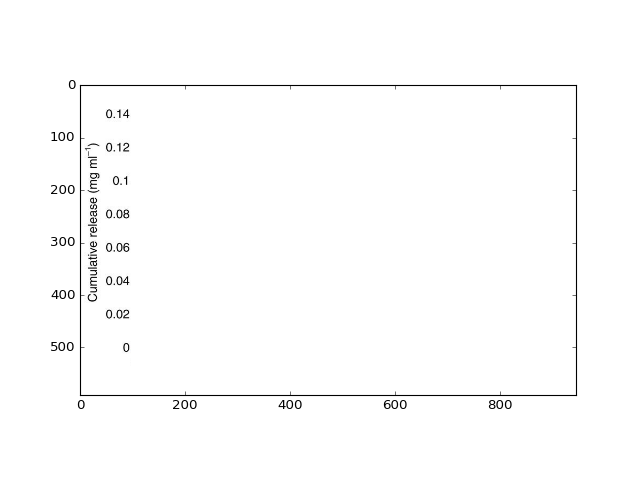

In [104]:
%matplotlib notebook
yTextImg = np.ones([m,n,p]).astype('uint8')*255
yTextImg[:,0:y_crop_ind-1,:]=img[:,0:y_crop_ind-1,:]

cv2.imwrite('temp/ytext.png',yTextImg)
implot = plt.imshow(yTextImg)

## Unfortunately

For OCR to work effectively on the y-axis, we must remove the rotated axis title completely. This is quite challenging.

<IPython.core.display.Javascript object>


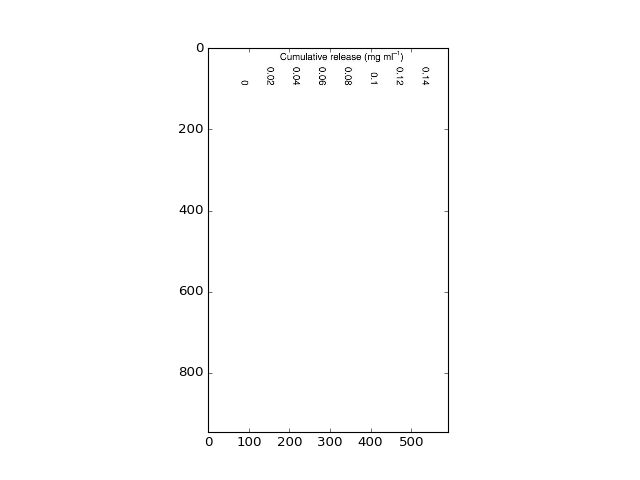

In [105]:
%matplotlib notebook

yTextRot = ndimage.interpolation.rotate(yTextImg, -90)
cv2.imwrite('temp/ytextrot.png',yTextRot)
implot = plt.imshow(yTextRot)
implot.set_cmap('gray')

In [108]:
yRotOcr = tes.image_to_string(Image.open('temp/ytextrot.png'),boxes=True)
print(yRotOcr)

O 82 852 99 864 0
9 145 879 162 896 0
o 145 865 162 877 0
m 146 852 162 864 0
C 177 914 192 931 0
u 195 914 205 927 0
m 208 914 224 927 0
u 227 914 237 927 0
l 240 914 242 931 0
a 245 914 256 927 0
t 257 914 263 930 0
i 265 914 267 931 0
v 269 914 280 927 0
e 281 914 292 927 0
r 301 914 307 927 0
e 308 914 319 927 0
l 322 914 324 931 0
e 326 914 337 927 0
a 339 914 351 927 0
s 352 914 363 927 0
e 364 914 375 927 0
( 384 909 389 931 0
m 392 914 409 927 0
g 411 909 422 927 0
m 431 914 448 927 0
l 451 914 453 931 0
“ 454 926 469 937 0
) 473 909 478 931 0
9 209 879 226 896 0
9 272 879 289 896 0
9 335 879 353 896 0
9 462 879 479 896 0
o 209 865 226 877 0
o 272 865 289 877 0
o 335 865 353 877 0
9 399 866 416 883 0
A 463 869 479 875 0
k 209 852 226 864 0
m 272 852 289 864 0
m 336 852 353 864 0
A 399 856 416 862 0
N 463 852 479 864 0
V 526 852 543 864 0
L 526 869 543 875 0
' 526 879 529 882 0
O 526 885 543 896 0


### Find the longest "word" and clear its bounding box

In [109]:
yrot_words = ocr_tools.clean_ocr_results(yRotOcr,charspace=10)
word_length = [len(i[0]) for i in yrot_words]
longest_word = np.array(word_length).argmax()
lwbox = yrot_words[longest_word]
lwbox

['Cumulativerelease', 177, 914, 375, 931]

<IPython.core.display.Javascript object>


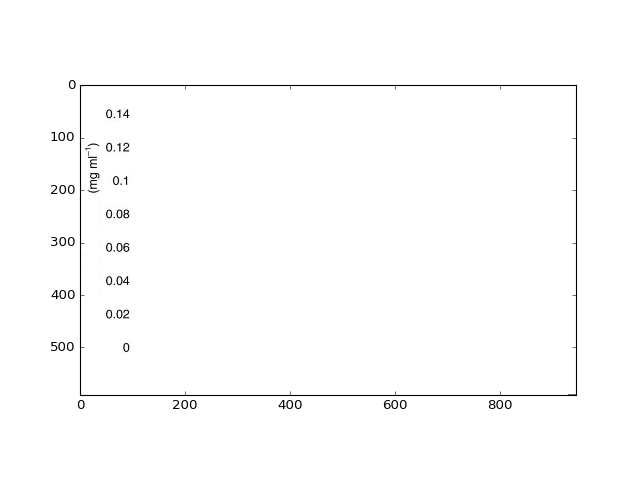

In [110]:
x1 = lwbox[1]-1
y1 = lwbox[2]-1
x2 = lwbox[3]+1
y2 = lwbox[4]+1
y1 = n-y1
y2 = n-y2
yTextRot[y2:y1+1,x1:x2+1,:] = np.ones([y1-y2+1,x2-x1+1,3]).astype('uint8')*255
yText_Clean = ndimage.interpolation.rotate(yTextRot, 90)

%matplotlib notebook
implot = plt.imshow(yText_Clean)

### Conventional OCR

In [111]:
cv2.imwrite('temp/ytextclean.png',yText_Clean)
yocr = tes.image_to_string(Image.open('temp/ytextclean.png'),boxes=True)
yl_ocr = ocr_tools.clean_ocr_results(yocr)
yl_ocr

[['0.14', 50, 526, 94, 543],
 ['A', 15, 473, 37, 478],
 ['0.12', 50, 462, 94, 479],
 ['(', 15, 384, 37, 389],
 ['m', 19, 392, 32, 409],
 ['g', 19, 411, 37, 422],
 ['m', 19, 431, 32, 448],
 ['l', 15, 451, 32, 453],
 ['\xe2\x80\x9c', 9, 454, 20, 469],
 ['0', 63, 399, 74, 416],
 ['0.08', 50, 335, 94, 353],
 ['0.06', 50, 272, 94, 289],
 ['0.04', 50, 209, 94, 226],
 ['0.02', 50, 145, 94, 162]]

In [112]:
yt_numbers = [w for w in yl_ocr if is_number(w[0])]
for w in yt_numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
yt_label_array = np.array(yt_numbers)
yt_label_array

array([[  1.40000000e-01,   5.00000000e+01,   6.50000000e+01,
          9.40000000e+01,   4.80000000e+01,   7.20000000e+01,
          5.60000000e+01],
       [  1.20000000e-01,   5.00000000e+01,   1.29000000e+02,
          9.40000000e+01,   1.12000000e+02,   7.20000000e+01,
          1.20000000e+02],
       [  0.00000000e+00,   6.30000000e+01,   1.92000000e+02,
          7.40000000e+01,   1.75000000e+02,   6.80000000e+01,
          1.83000000e+02],
       [  8.00000000e-02,   5.00000000e+01,   2.56000000e+02,
          9.40000000e+01,   2.38000000e+02,   7.20000000e+01,
          2.47000000e+02],
       [  6.00000000e-02,   5.00000000e+01,   3.19000000e+02,
          9.40000000e+01,   3.02000000e+02,   7.20000000e+01,
          3.10000000e+02],
       [  4.00000000e-02,   5.00000000e+01,   3.82000000e+02,
          9.40000000e+01,   3.65000000e+02,   7.20000000e+01,
          3.73000000e+02],
       [  2.00000000e-02,   5.00000000e+01,   4.46000000e+02,
          9.40000000e+01,   4.29

<IPython.core.display.Javascript object>


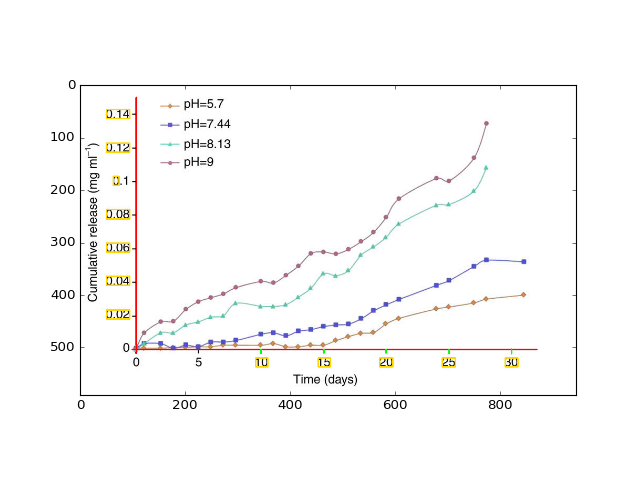

In [113]:
%matplotlib notebook

for w in yt_numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

## Now run the same label/tick matching algorithm for the y-axis

In [114]:
yt_dirty = find_axes.get_yticks(nbw,yax,tickMargin=11,minTickLen=0,maxGap=2)
yt_list=yt_dirty.tolist()
yt_match = find_axes.match_xticks(yt_numbers,yt_list)
yt_pts = [yt_list[i] for i in yt_match]
yt_pts

[[99, 57, 107, 57],
 [99, 122, 107, 122],
 [99, 185, 107, 185],
 [99, 249, 107, 249],
 [99, 313, 107, 313],
 [99, 377, 107, 377],
 [99, 441, 107, 441]]

<IPython.core.display.Javascript object>


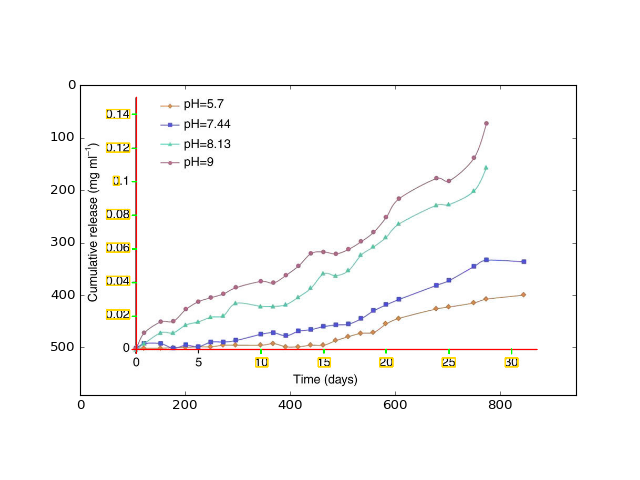

In [115]:
%matplotlib notebook
for x1,y1,x2,y2 in yt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [117]:
yt_pts_array = np.array(yt_pts)
print('y axis pixels')
print(yt_pts_array[:,1].reshape(-1,1))

y axis pixels
[[ 57]
 [122]
 [185]
 [249]
 [313]
 [377]
 [441]]


In [118]:
print('y axis data')
print(yt_label_array[:,0].reshape(-1,1))

y axis data
[[ 0.14]
 [ 0.12]
 [ 0.  ]
 [ 0.08]
 [ 0.06]
 [ 0.04]
 [ 0.02]]


## Regress the y tick labels to the y ticks

In [120]:
from sklearn import datasets, linear_model
regry = linear_model.LinearRegression(fit_intercept=True)

regry.fit(yt_pts_array[:,1].reshape(-1,1), yt_label_array[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regry.coef_
print 'Intercept: \n', regry.intercept_

Coefficients: 
[[-0.00025679]]
Intercept: 
[ 0.12969277]


## Finally, Extract the Data by Clustering

This is where the problem explodes. This is not a universal approach.

In [121]:
from color_series_scrape import color_series_scrape

pix_pts, ROI = color_series_scrape(example, [[xax[0],xax[2]]],[[yax[3],yax[1]]], n_colors=4)

print('Done clustering')

KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image
Done clustering


KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


<IPython.core.display.Javascript object>


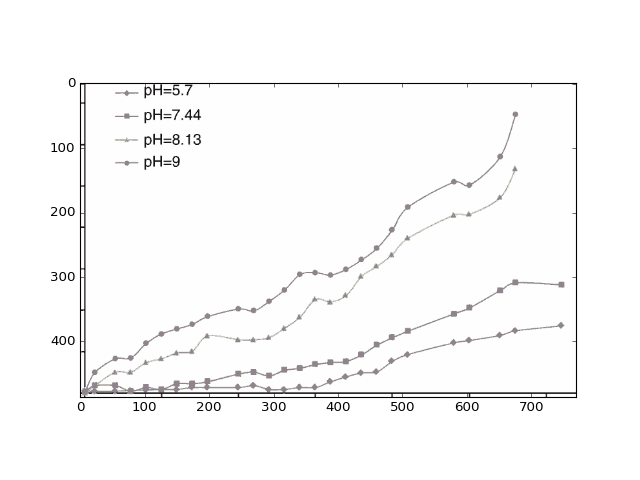

In [122]:
from cluster_data import cluster_colorspace_km, return_series

im_recon, im_label = cluster_colorspace_km(ROI[0], 4)
labels_as_ims = return_series(im_label)

%matplotlib notebook
plt.imshow(im_recon)

<IPython.core.display.Javascript object>


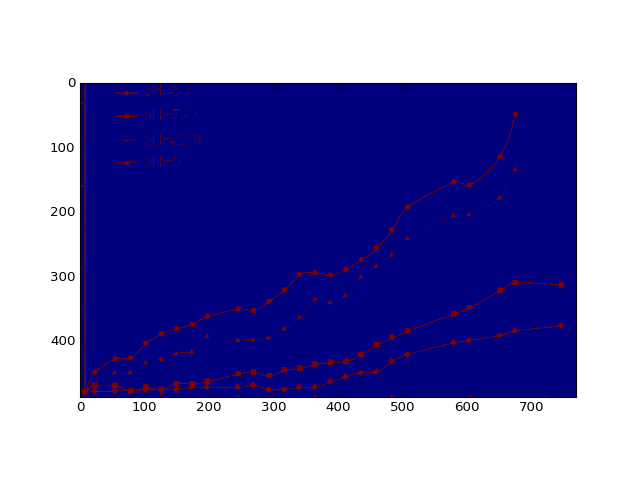

In [124]:
%matplotlib notebook

plt.imshow(labels_as_ims[0])

<IPython.core.display.Javascript object>


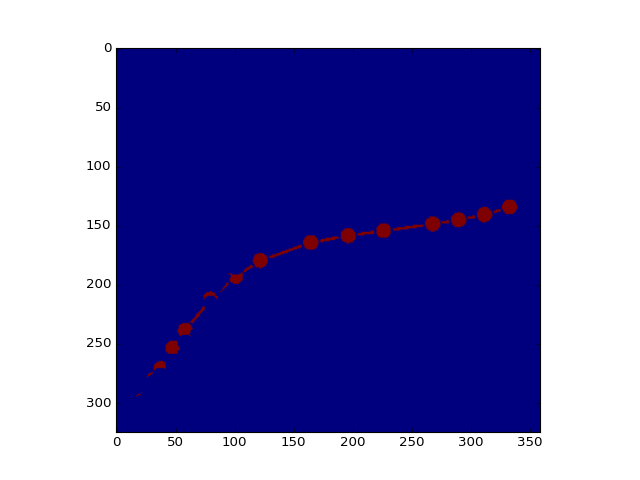

In [78]:
%matplotlib notebook

plt.imshow(labels_as_ims[1])

<IPython.core.display.Javascript object>


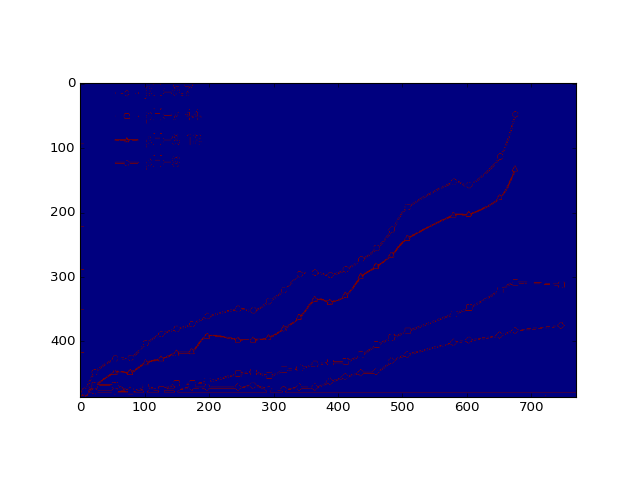

In [125]:
%matplotlib notebook

plt.imshow(labels_as_ims[2])

<IPython.core.display.Javascript object>


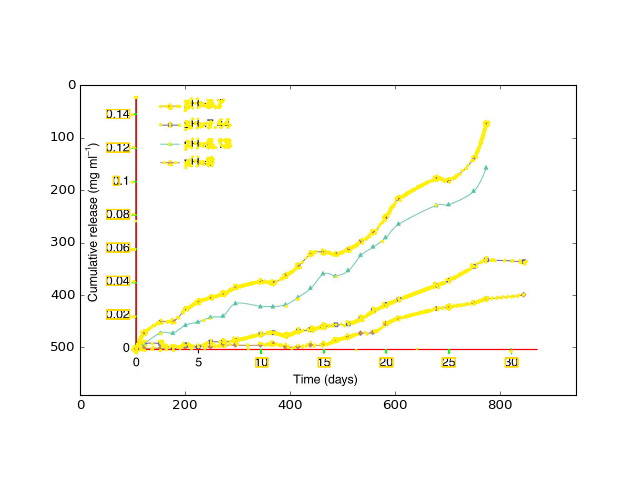

In [126]:
%matplotlib notebook
imlabel4 = imlabel.copy()
pp_list = []
for series in pix_pts[0]:
    s_list = []
    for tup in series:
        x = int(round(tup[1]))+xax[0]
        y = int(round(tup[0]))+yax[3]
        s_list.append([x,y])
    pp_list.append(s_list)

pp_list

for series in pp_list:
    for pt in series:
        cv2.circle(imlabel4,(pt[0],pt[1]), 3, (255,240,10), -1)


lastplot = plt.imshow(imlabel4)

## ... and convert the pixel values to the units of the axes

In [127]:
data_list = []
for series in pp_list:
    ser_list = []
    for pt in series:
        xdata = pt[0]*regrx.coef_+regrx.intercept_
        ydata = pt[1]*regry.coef_+regry.intercept_
        ser_list.append([xdata[0,0],ydata[0,0]])
    data_list.append(ser_list[::-1])

data_list

[[[-0.030852997411344507, 0.000781993183775892],
  [0.165499280054763, 0.001038787561015192],
  [0.30014084174580813, 0.001552376315493792],
  [0.2300150283650555, 0.0023227594472117197],
  [0.098178499209240433, 0.0033499369561689196],
  [0.43197737090162325, 0.0036067313334082196],
  [0.36746162259133075, 0.0038635257106475474],
  [0.49929815174714576, 0.0048907032196047473],
  [0.76858127512923602, 0.0069450582375191888],
  [0.633939713438191, 0.0077154413692371027],
  [0.70126049428371351, 0.0084858245009550165],
  [0.83309702343952852, 0.0092562076326729303],
  [0.90041780428505125, 0.010026590764390844],
  [0.96773858513057376, 0.011567357027826672],
  [1.0350593659760963, 0.012337740159544586],
  [1.102380146821619, 0.012594534536783886],
  [1.1668958951319113, 0.015419272686416241],
  [1.234216675977434, 0.01927118834500581],
  [1.3015374568229565, 0.022095926494638152],
  [1.3716632702037093, 0.024663870267031193],
  [1.5708205802050468, 0.031597318452492418],
  [1.63814136105

## Broader Problem: How to identify Graphs?

In [40]:
spat_stats_path = '/Users/Imperssonator/CC/MIC-Pres/SS PCA presentation/Slide1.tiff'
ss_img = cv2.imread(spat_stats_path)

<IPython.core.display.Javascript object>


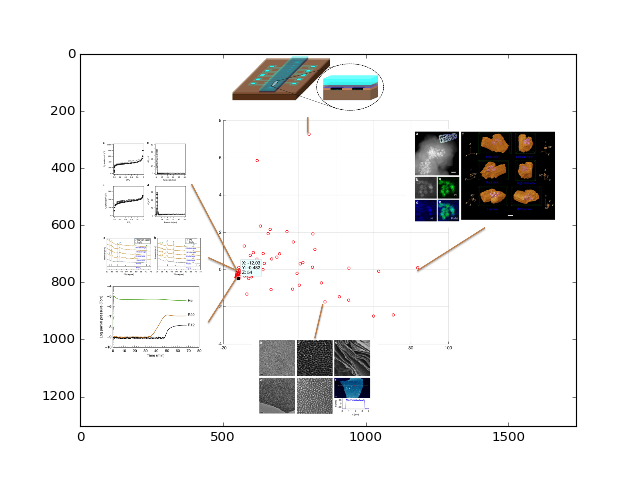

In [41]:
%matplotlib notebook
plt.imshow(ss_img)